
# Experiment 2 — Frozen Encoder + Bayesian Head (3-way MCQ)

This notebook builds a **multiple-choice QA** pipeline using a **frozen Hugging Face encoder** (e.g., DistilBERT) to get text features, then applies a **Bayesian multinomial logistic regression head** (NumPyro + NUTS) over **3 options** per question.

You get:
- Posterior over head weights (small parameter set → feasible HMC/NUTS)
- **Posterior predictive** per question (3-class)
- **Abstention** via confidence threshold
- **Reliability diagram** and **Selective prediction (accuracy vs coverage)**

> Educational by design; small datasets recommended.



## Setup

Install packages (inside your Pipenv) if needed:

```bash
pipenv run pip install transformers datasets accelerate sentencepiece     numpyro==0.15.2 "jax[cpu]==0.4.28" scikit-learn pandas matplotlib
```



## 1) Data: tiny MCQ format

You can either **provide your own CSV** with columns: `question, option_a, option_b, option_c, label` (label in {0,1,2}), **or** use the toy examples defined below.


In [4]:
rows = [
    # --- Label 0 ---
    {"question": "Which planet is known as the Red Planet?", "option_a": "Mars", "option_b": "Venus", "option_c": "Jupiter", "label": 0},
    {"question": "Capital of France?", "option_a": "Paris", "option_b": "Berlin", "option_c": "Madrid", "label": 0},
    {"question": "Which animal barks?", "option_a": "dog", "option_b": "cat", "option_c": "cow", "label": 0},
    {"question": "Which country hosted the 2016 Summer Olympics?", "option_a": "Brazil", "option_b": "China", "option_c": "UK", "label": 0},
    {"question": "Who discovered penicillin?", "option_a": "Alexander Fleming", "option_b": "Marie Curie", "option_c": "Louis Pasteur", "label": 0},
    {"question": "What is the capital of Japan?", "option_a": "Kyoto", "option_b": "Tokyo", "option_c": "Osaka", "label": 0},
    {"question": "Which is the fastest land animal?", "option_a": "Cheetah", "option_b": "Horse", "option_c": "Lion", "label": 0},
    {"question": "Who wrote 'Romeo and Juliet'?", "option_a": "William Shakespeare", "option_b": "Charles Dickens", "option_c": "Mark Twain", "label": 0},
    {"question": "Which gas is essential for respiration?", "option_a": "Oxygen", "option_b": "Carbon monoxide", "option_c": "Helium", "label": 0},
    {"question": "Which continent is Egypt located in?", "option_a": "Africa", "option_b": "Asia", "option_c": "Europe", "label": 0},
    {"question": "Which instrument has keys, pedals, and strings?", "option_a": "Piano", "option_b": "Flute", "option_c": "Drum", "label": 0},
    {"question": "What is H2O commonly known as?", "option_a": "Water", "option_b": "Hydrogen", "option_c": "Ozone", "label": 0},
    {"question": "Which country is famous for the pyramids at Giza?", "option_a": "Egypt", "option_b": "Mexico", "option_c": "Peru", "label": 0},
    {"question": "Which device measures temperature?", "option_a": "Thermometer", "option_b": "Altimeter", "option_c": "Speedometer", "label": 0},
    {"question": "Which planet is closest to the Sun?", "option_a": "Mercury", "option_b": "Venus", "option_c": "Earth", "label": 0},
    {"question": "What gas do plants primarily absorb?", "option_a": "Carbon dioxide", "option_b": "Oxygen", "option_c": "Nitrogen", "label": 0},
    {"question": "What currency is used in Japan?", "option_a": "Yen", "option_b": "Won", "option_c": "Yuan", "label": 0},
    {"question": "Which mammal can truly fly?", "option_a": "Bat", "option_b": "Flying squirrel", "option_c": "Chicken", "label": 0},
    {"question": "Which ocean borders California?", "option_a": "Pacific Ocean", "option_b": "Atlantic Ocean", "option_c": "Indian Ocean", "label": 0},
    {"question": "What is the hardest natural substance?", "option_a": "Diamond", "option_b": "Steel", "option_c": "Quartz", "label": 0},
    {"question": "What do bees collect from flowers?", "option_a": "Nectar", "option_b": "Dew", "option_c": "Sap", "label": 0},
    {"question": "Which sport uses a shuttlecock?", "option_a": "Badminton", "option_b": "Tennis", "option_c": "Cricket", "label": 0},
    {"question": "Who developed the theory of relativity?", "option_a": "Albert Einstein", "option_b": "Isaac Newton", "option_c": "Niels Bohr", "label": 0},
    {"question": "Which continent is the Sahara Desert on?", "option_a": "Africa", "option_b": "Asia", "option_c": "Australia", "label": 0},
    {"question": "Which organ is primarily responsible for filtering blood?", "option_a": "Kidneys", "option_b": "Liver", "option_c": "Pancreas", "label": 0},
    {"question": "Which natural satellite orbits Earth?", "option_a": "The Moon", "option_b": "Phobos", "option_c": "Europa", "label": 0},
    {"question": "What is the tallest land animal?", "option_a": "Giraffe", "option_b": "Elephant", "option_c": "Moose", "label": 0},
    {"question": "What is the main language spoken in Brazil?", "option_a": "Portuguese", "option_b": "Spanish", "option_c": "French", "label": 0},
    {"question": "What is the chemical symbol for sodium?", "option_a": "Na", "option_b": "So", "option_c": "Sn", "label": 0},
    {"question": "Which city is the Colosseum located in?", "option_a": "Rome", "option_b": "Athens", "option_c": "Istanbul", "label": 0},
    {"question": "Which animal is known as the 'ship of the desert'?", "option_a": "Camel", "option_b": "Donkey", "option_c": "Llama", "label": 0},
    {"question": "Which British city is Big Ben in?", "option_a": "London", "option_b": "Edinburgh", "option_c": "Manchester", "label": 0},
    {"question": "What part of the plant conducts photosynthesis?", "option_a": "Leaves", "option_b": "Roots", "option_c": "Stem", "label": 0},
    {"question": "Which organ helps humans breathe?", "option_a": "Lungs", "option_b": "Spleen", "option_c": "Gallbladder", "label": 0},
    {"question": "Which country gifted the Statue of Liberty to the USA?", "option_a": "France", "option_b": "Italy", "option_c": "Spain", "label": 0},
    {"question": "Which ocean is the smallest by area?", "option_a": "Arctic Ocean", "option_b": "Southern Ocean", "option_c": "Atlantic Ocean", "label": 0},
    {"question": "Which vitamin is produced when sunlight hits the skin?", "option_a": "Vitamin D", "option_b": "Vitamin C", "option_c": "Vitamin K", "label": 0},

    # --- Label 1 ---
    {"question": "What color are bananas when ripe?", "option_a": "red", "option_b": "yellow", "option_c": "blue", "label": 1},
    {"question": "How many continents are there?", "option_a": "Five", "option_b": "Seven", "option_c": "Six", "label": 1},
    {"question": "Who painted the Mona Lisa?", "option_a": "Michelangelo", "option_b": "Leonardo da Vinci", "option_c": "Raphael", "label": 1},
    {"question": "What is the boiling point of water at sea level (°C)?", "option_a": "90", "option_b": "100", "option_c": "110", "label": 1},
    {"question": "2 + 2 equals?", "option_a": "3", "option_b": "4", "option_c": "5", "label": 1},
    {"question": "How many players are on a standard soccer team (on field)?", "option_a": "9", "option_b": "11", "option_c": "12", "label": 1},
    {"question": "Which element has the symbol 'O'?", "option_a": "Osmium", "option_b": "Oxygen", "option_c": "Gold", "label": 1},
    {"question": "Which shape has three sides?", "option_a": "Square", "option_b": "Triangle", "option_c": "Pentagon", "label": 1},
    {"question": "What is the largest mammal?", "option_a": "Elephant", "option_b": "Blue Whale", "option_c": "Giraffe", "label": 1},
    {"question": "Which ocean is the largest?", "option_a": "Pacific Ocean", "option_b": "Atlantic Ocean", "option_c": "Indian Ocean", "label": 1},
    {"question": "Which metal is most abundant in Earth’s crust?", "option_a": "Iron", "option_b": "Aluminum", "option_c": "Copper", "label": 1},
    {"question": "How many degrees are in a right angle?", "option_a": "45", "option_b": "90", "option_c": "120", "label": 1},
    {"question": "Which planet is famous for its rings?", "option_a": "Jupiter", "option_b": "Saturn", "option_c": "Uranus", "label": 1},
    {"question": "The square root of 81 is?", "option_a": "7", "option_b": "9", "option_c": "11", "label": 1},
    {"question": "Which blood type is a universal donor?", "option_a": "AB+", "option_b": "O−", "option_c": "A−", "label": 1},
    {"question": "What is the capital of Canada?", "option_a": "Toronto", "option_b": "Ottawa", "option_c": "Vancouver", "label": 1},
    {"question": "Which country has the city of Barcelona?", "option_a": "Portugal", "option_b": "Spain", "option_c": "France", "label": 1},
    {"question": "What is the process of water turning to vapor?", "option_a": "Condensation", "option_b": "Evaporation", "option_c": "Sublimation", "label": 1},
    {"question": "Which organ stores bile?", "option_a": "Pancreas", "option_b": "Gallbladder", "option_c": "Appendix", "label": 1},
    {"question": "In computing, what does 'CPU' stand for?", "option_a": "Central Process Unit", "option_b": "Central Processing Unit", "option_c": "Computer Processing Unit", "label": 1},
    {"question": "Which constellation contains the North Star?", "option_a": "Orion", "option_b": "Ursa Minor", "option_c": "Cassiopeia", "label": 1},
    {"question": "How many weeks are there in a year (approx.)?", "option_a": "50", "option_b": "52", "option_c": "54", "label": 1},
    {"question": "Which mammal lays eggs?", "option_a": "Kangaroo", "option_b": "Platypus", "option_c": "Koala", "label": 1},
    {"question": "Which continent has the most countries?", "option_a": "Asia", "option_b": "Africa", "option_c": "Europe", "label": 1},
    {"question": "Which gas makes up most of Earth’s atmosphere?", "option_a": "Oxygen", "option_b": "Nitrogen", "option_c": "Carbon dioxide", "label": 1},
    {"question": "Which layer of Earth do we live on?", "option_a": "Mantle", "option_b": "Crust", "option_c": "Core", "label": 1},
    {"question": "Which Italian city is famous for canals?", "option_a": "Rome", "option_b": "Venice", "option_c": "Florence", "label": 1},
    {"question": "What is the main gas in the Sun?", "option_a": "Helium", "option_b": "Hydrogen", "option_c": "Neon", "label": 1},
    {"question": "Which sport is known as 'the beautiful game'?", "option_a": "Basketball", "option_b": "Football (soccer)", "option_c": "Rugby", "label": 1},
    {"question": "Which desert covers much of northern Africa?", "option_a": "Gobi", "option_b": "Sahara", "option_c": "Kalahari", "label": 1},
    {"question": "What is the freezing point of water (°C)?", "option_a": "−10", "option_b": "0", "option_c": "5", "label": 1},
    {"question": "What is the chemical symbol for potassium?", "option_a": "Po", "option_b": "K", "option_c": "Pt", "label": 1},
    {"question": "Which country’s flag features a maple leaf?", "option_a": "USA", "option_b": "Canada", "option_c": "Denmark", "label": 1},
    {"question": "Which author wrote '1984'?", "option_a": "Aldous Huxley", "option_b": "George Orwell", "option_c": "Ray Bradbury", "label": 1},
    {"question": "How many states are in the USA?", "option_a": "48", "option_b": "50", "option_c": "52", "label": 1},
    {"question": "Which is the longest river in the world (by many measures)?", "option_a": "Amazon (debatable)", "option_b": "Nile", "option_c": "Yangtze", "label": 1},
    {"question": "Which number is a prime?", "option_a": "21", "option_b": "23", "option_c": "25", "label": 1},
    {"question": "Which branch of math deals with shapes and sizes?", "option_a": "Algebra", "option_b": "Geometry", "option_c": "Calculus", "label": 1},
    {"question": "Which continent is New Zealand part of (regionally)?", "option_a": "Asia", "option_b": "Oceania", "option_c": "Europe", "label": 1},

    # --- Label 2 ---
    {"question": "Which organ pumps blood in the human body?", "option_a": "Lungs", "option_b": "Brain", "option_c": "Heart", "label": 2},
    {"question": "The Sun is a ...", "option_a": "planet", "option_b": "comet", "option_c": "star", "label": 2},
    {"question": "Which metal is liquid at room temperature?", "option_a": "Mercury", "option_b": "Iron", "option_c": "Aluminum", "label": 2},
    {"question": "The Great Wall is located in which country?", "option_a": "India", "option_b": "China", "option_c": "Japan", "label": 2},
    {"question": "Which planet has the most moons?", "option_a": "Jupiter", "option_b": "Saturn", "option_c": "Neptune", "label": 2},
    {"question": "Which gas do humans exhale?", "option_a": "Oxygen", "option_b": "Carbon dioxide", "option_c": "Nitrogen", "label": 2},
    {"question": "What is the chemical symbol for gold?", "option_a": "Ag", "option_b": "Au", "option_c": "Pb", "label": 1},  # (still 1, balances slightly)
    {"question": "Which city is known as the Big Apple?", "option_a": "New York", "option_b": "Los Angeles", "option_c": "Chicago", "label": 0},
    {"question": "Which country is both in Europe and Asia?", "option_a": "Turkey", "option_b": "Spain", "option_c": "Mexico", "label": 0},
    {"question": "Which month has 28 days?", "option_a": "February", "option_b": "June", "option_c": "November", "label": 0},
    {"question": "What do we call animals that eat only plants?", "option_a": "Carnivores", "option_b": "Omnivores", "option_c": "Herbivores", "label": 2},
    {"question": "Which planet is known for a Great Red Spot storm?", "option_a": "Saturn", "option_b": "Neptune", "option_c": "Jupiter", "label": 2},
    {"question": "Which instrument uses a reed to make sound?", "option_a": "Trumpet", "option_b": "Violin", "option_c": "Clarinet", "label": 2},
    {"question": "Which scientist proposed the three laws of motion?", "option_a": "Einstein", "option_b": "Galileo", "option_c": "Isaac Newton", "label": 2},
    {"question": "What is the capital city of Australia?", "option_a": "Sydney", "option_b": "Melbourne", "option_c": "Canberra", "label": 2},
    {"question": "Which device converts sound waves to electrical signals?", "option_a": "Speaker", "option_b": "Tuning fork", "option_c": "Microphone", "label": 2},
    {"question": "What do we call molten rock beneath Earth’s surface?", "option_a": "Lava", "option_b": "Sediment", "option_c": "Magma", "label": 2},
    {"question": "Which vitamin is abundant in citrus fruits?", "option_a": "Vitamin A", "option_b": "Vitamin D", "option_c": "Vitamin C", "label": 2},
    {"question": "Which city is known as 'the Big Smoke' in the UK?", "option_a": "Liverpool", "option_b": "Birmingham", "option_c": "London", "label": 2},
    {"question": "Which animal is a marsupial?", "option_a": "Panda", "option_b": "Wolf", "option_c": "Kangaroo", "label": 2},
    {"question": "Which layer protects Earth from UV radiation?", "option_a": "Troposphere", "option_b": "Ionosphere", "option_c": "Ozone layer", "label": 2},
    {"question": "What is the process of plants making food?", "option_a": "Fermentation", "option_b": "Respiration", "option_c": "Photosynthesis", "label": 2},
    {"question": "What is the capital of Italy?", "option_a": "Milan", "option_b": "Naples", "option_c": "Rome", "label": 2},
    {"question": "Which is the largest planet in our solar system?", "option_a": "Earth", "option_b": "Saturn", "option_c": "Jupiter", "label": 2},
    {"question": "What is 3.14 commonly called?", "option_a": "Euler’s number", "option_b": "Golden ratio", "option_c": "Pi", "label": 2},
    {"question": "What is the main component of table salt?", "option_a": "Calcium chloride", "option_b": "Potassium nitrate", "option_c": "Sodium chloride", "label": 2},
    {"question": "Which continent is Argentina in?", "option_a": "Europe", "option_b": "Africa", "option_c": "South America", "label": 2},
    {"question": "Which mammal is the largest on Earth?", "option_a": "African elephant", "option_b": "Sperm whale", "option_c": "Blue whale", "label": 2},
    {"question": "Which sport features a 'try' as a score?", "option_a": "Baseball", "option_b": "Basketball", "option_c": "Rugby", "label": 2},
    {"question": "Which metal has the symbol 'Fe'?", "option_a": "Lead", "option_b": "Tin", "option_c": "Iron", "label": 2},
    {"question": "Which city hosted the 2020 (held 2021) Summer Olympics?", "option_a": "Rio de Janeiro", "option_b": "Beijing", "option_c": "Tokyo", "label": 2},
    {"question": "Which organ produces insulin?", "option_a": "Liver", "option_b": "Spleen", "option_c": "Pancreas", "label": 2},
    {"question": "What is the boiling point of water in Kelvin?", "option_a": "283 K", "option_b": "293 K", "option_c": "373 K", "label": 2},
    {"question": "Which continent is home to the Amazon rainforest?", "option_a": "Africa", "option_b": "Asia", "option_c": "South America", "label": 2},
    {"question": "Which gas is used to fill balloons to make them float?", "option_a": "Hydrogen (unsafe)", "option_b": "Oxygen", "option_c": "Helium", "label": 2},
    {"question": "What is the capital of South Korea?", "option_a": "Busan", "option_b": "Incheon", "option_c": "Seoul", "label": 2},
    {"question": "Which art movement is Pablo Picasso associated with?", "option_a": "Impressionism", "option_b": "Surrealism", "option_c": "Cubism", "label": 2},
    {"question": "Which river runs through Egypt?", "option_a": "Amazon", "option_b": "Danube", "option_c": "Nile", "label": 2},
    {"question": "Which continent is the country of Ghana in?", "option_a": "Europe", "option_b": "South America", "option_c": "Africa", "label": 2},
    {"question": "Which organ primarily detoxifies chemicals in the body?", "option_a": "Kidney", "option_b": "Lung", "option_c": "Liver", "label": 2},
    {"question": "Which particle carries a negative charge?", "option_a": "Proton", "option_b": "Neutron", "option_c": "Electron", "label": 2},
    {"question": "Which structure connects muscle to bone?", "option_a": "Ligament", "option_b": "Cartilage", "option_c": "Tendon", "label": 2},
    {"question": "Which festival is known as the Festival of Lights in India?", "option_a": "Holi", "option_b": "Eid", "option_c": "Diwali", "label": 2},
    {"question": "Which Scandinavian country uses the krone and has Oslo as capital?", "option_a": "Sweden", "option_b": "Denmark", "option_c": "Norway", "label": 2},
    {"question": "Which field studies fossils and ancient life?", "option_a": "Geography", "option_b": "Archaeology", "option_c": "Paleontology", "label": 2},
]   

import pandas as pd
df = pd.DataFrame(rows)
df['label'].value_counts()

label
2    41
0    40
1    40
Name: count, dtype: int64


## 2) Frozen encoder → features

We encode each (question, option) pair and grab the **[CLS]** representation. For 3 options, we either **concatenate** the three vectors into one long feature vector (simple) or model them as a 3-class softmax with a shared weight matrix. Here we choose **concatenation** to keep the Bayesian head linear and compact.


In [5]:

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

mdl_name = "distilbert-base-uncased"  # choose any encoder; frozen
tok = AutoTokenizer.from_pretrained(mdl_name)
enc = AutoModel.from_pretrained(mdl_name)
enc.eval(); enc.requires_grad_(False)

def encode_pair(q, a, max_length=128):
    t = tok(q, a, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        out = enc(**t)
        cls = out.last_hidden_state[:, 0, :]  # (1, D)
    return cls.squeeze(0).cpu().numpy()  # (D,)

def build_design_tensor(df):
    feats = []
    y = []
    for _, row in df.iterrows():
        q = str(row["question"])
        opts = [str(row["option_a"]), str(row["option_b"]), str(row["option_c"])]
        vecs = [encode_pair(q, a) for a in opts]  # list of 3 x (D,)
        feats.append(np.stack(vecs, axis=0))      # (3, D)
        y.append(int(row["label"]))
    X = np.stack(feats, axis=0).astype(np.float32)  # (N, 3, D)
    y = np.array(y, dtype=np.int32)
    return X, y

X, y = build_design_tensor(df)   # X:(N,3,D)
X.shape, y.shape


((121, 3, 768), (121,))


## 3) Train/validation split


In [8]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if len(np.unique(y))>1 else None
)

# flatten options for scaling, then reshape back
N, C, D = X.shape
X_flat = X.reshape(N*C, D)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_flat)
X = scaler.transform(X_flat).reshape(N, C, D).astype(np.float32)

X_train.shape, X_test.shape


((90, 3, 768), (31, 3, 768))


## 4) Bayesian multinomial logistic regression (NumPyro + NUTS)

Small parameter set: `(3*D) × 3 + 3` → feasible HMC/NUTS.


In [95]:

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

N, C, D = X_train.shape

'''
def bayes_head_opt(X, y=None):
    # W: (D, C), b: (C,)
    W = numpyro.sample("W", dist.Normal(0, 1).expand([D, C]).to_event(2))
    b = numpyro.sample("b", dist.Normal(0, 1).expand([C]).to_event(1))
    # logits: (N, C) where logits[n,c] = X[n,c,:] · W[:,c] + b[c]
    logits = (X * W.T).sum(axis=-1) + b  # broadcasting: W.T -> (C, D)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Categorical(logits=logits), obs=y)
'''

def bayes_head_opt(X, y=None):
    """
    X: (N, C, D)  per-option features (already standardized if possible)
    y: (N,)       integer labels in [0, C-1]
    """
    N, C, D = X.shape

    # --- hierarchical shrinkage on weights W: (C, D) ---
    # Non-centered param: W = tau * z  with z ~ N(0,1)
    # You can also make tau per-class: tau ~ HalfCauchy(1).expand([C])
    tau = numpyro.sample("tau", dist.HalfCauchy(1.0))
    zW  = numpyro.sample("zW",  dist.Normal(0., 1.).expand([C, D]).to_event(2))
    W   = numpyro.deterministic("W", tau * zW)                # (C, D)

    # --- intercepts with mild prior ---
    b   = numpyro.sample("b", dist.Normal(0., 2.).expand([C]).to_event(1))  # (C,)

    # --- logits[n, c] = <X[n, c, :], W[c, :]> + b[c] ---
    # Use einsum for clarity & to avoid silent broadcasting issues
    logits = jnp.einsum("ncd,cd->nc", X, W) + b  # (N, C)

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.CategoricalLogits(logits), obs=y)


rng_key = jax.random.PRNGKey(0)

nuts = NUTS(
    bayes_head_opt,
    dense_mass=False,          # faster than dense for this size
    target_accept_prob=0.90,   # easier steps
    max_tree_depth=8,          # cap exploration
)

mcmc = MCMC(
    nuts,
    num_warmup=500,            # ↓ warmup
    num_samples=2000,           # ↓ samples
    num_chains=4,              # 1 chain
    chain_method="parallel",   # avoids vectorized overhead on CPU
    progress_bar=True,
)

mcmc.run(rng_key, X=jnp.array(X_train), y=jnp.array(y_train))
posterior = mcmc.get_samples()
mcmc.print_summary()


/var/folders/gy/rrks26hj5sqf6d7jw7qtnmh00000gn/T/ipykernel_41011/3441615272.py:54: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2500/2500 [00:03<00:00, 813.18it/s, 31 steps of size 1.30e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b[0]     -0.03      1.18     -0.06     -1.86      2.03   3729.03      1.00
      b[1]      0.02      1.18     -0.01     -1.95      1.89   3794.79      1.00
      b[2]     -0.01      1.18     -0.04     -2.02      1.88   3773.54      1.00
       tau      0.03      0.04      0.03      0.00      0.06    444.20      1.01
   zW[0,0]      0.01      0.99      0.00     -1.61      1.64  11529.00      1.00
   zW[0,1]      0.09      1.00      0.10     -1.63      1.63  13222.01      1.00
   zW[0,2]     -0.03      0.98     -0.04     -1.55      1.71  11933.58      1.00
   zW[0,3]      0.05      0.99      0.05     -1.61      1.64  14229.30      1.00
   zW[0,4]      0.03      0.98      0.02     -1.68      1.54  13683.90      1.00
   zW[0,5]     -0.10      1.00     -0.11     -1.76      1.51  13809.73      1.00
   zW[0,6]     -0.01      0.98     -0.01     -1.61      1.61  10673.16      1.00
   zW[0,7]     -0.03      0

In [96]:
import numpy as np

def save_posterior(mcmc, path="posterior_samples.npz"):
    """
    Save posterior samples from a NumPyro MCMC run.

    Args:
        mcmc: NumPyro MCMC object (after .run())
        path: file path (default 'posterior_samples.npz')
    """
    posterior = mcmc.get_samples()
    np.savez(path, **posterior)
    print(f"✅ Posterior samples saved to {path}")


def load_posterior(path="posterior_samples.npz"):
    """
    Load posterior samples saved with save_posterior().

    Args:
        path: file path
    Returns:
        dict[str, np.ndarray]: posterior samples
    """
    data = np.load(path)
    posterior = {k: data[k] for k in data.files}
    print(f"✅ Posterior samples loaded from {path} (keys: {list(posterior.keys())})")
    return posterior

In [97]:
save_posterior(mcmc, "iris_posterior.npz")

✅ Posterior samples saved to iris_posterior.npz


In [98]:
posterior = load_posterior("iris_posterior.npz")

✅ Posterior samples loaded from iris_posterior.npz (keys: ['W', 'b', 'tau', 'zW'])



## 5) Posterior predictive, metrics, abstention


In [99]:
import numpy as np

import numpy as np

def predict_proba_per_option(X_ncd, post):
    """
    Posterior-mean class probabilities for per-option features.

    Args:
        X_ncd : (N, C, D)  features (per example n, class c, dim d)
        post  : dict with
            - "W": (S, D, C) or (S, C, D) posterior samples of weights
            - "b": (S, C) or (C,)        posterior samples of biases
    Returns:
        (N, C) posterior-mean probabilities.
    """
    X_ncd = np.asarray(X_ncd)
    N, C, D = X_ncd.shape

    W = np.asarray(post["W"])
    b = np.asarray(post["b"])

    # Ensure sample axis exists
    if W.ndim == 2:  # (D, C) or (C, D) -> add sample dim
        W = W[None, ...]
    S = W.shape[0]

    # Normalize W to (S, D, C)
    if W.shape[1:] == (D, C):
        W_sdc = W
    elif W.shape[1:] == (C, D):
        W_sdc = np.swapaxes(W, 1, 2)  # (S, C, D) -> (S, D, C)
    else:
        raise ValueError(f"Incompatible W shape {W.shape} for X {X_ncd.shape}")

    # Normalize b to (S, C)
    if b.ndim == 1:         # (C,)
        b_sc = b[None, :]   # -> (1, C) broadcast over S
        if S > 1:
            b_sc = np.tile(b_sc, (S, 1))
    elif b.shape == (S, C):
        b_sc = b
    elif b.shape == (C, S):
        b_sc = b.T
    else:
        raise ValueError(f"Incompatible b shape {b.shape} for S={S}, C={C}")

    # logits_{s,n,c} = < X[n,c,:], W[s,:,c] > + b[s,c]
    logits_snc = np.einsum('ncd,sdc->snc', X_ncd, W_sdc) + b_sc[:, None, :]  # (S,N,C)

    # stable softmax per (s,n,*)
    logits_snc -= logits_snc.max(axis=-1, keepdims=True)
    p_snc = np.exp(logits_snc)
    p_snc /= p_snc.sum(axis=-1, keepdims=True)

    # posterior predictive mean over samples
    return p_snc.mean(axis=0)  # (N, C)

In [100]:
p_te = predict_proba_per_option(X_test, posterior)
#p_bar = predict_proba_auto(X_test, posterior)


### Selective prediction: accuracy vs coverage


In [101]:
import numpy as np

def selective_curve(probs, y_true, min_answers=5, include_equal=True):
    """
    Build a well-behaved accuracy-vs-coverage curve by sweeping thresholds
    over the *actual* unique confidence values.

    Args
    ----
    probs : (N, C) posterior-mean probabilities
    y_true: (N,) integer labels
    min_answers : int, drop points with fewer than this many answered items
    include_equal: bool, if True use conf >= tau, else conf > tau

    Returns
    -------
    coverages : (K,) fraction answered at each tau
    accuracies: (K,) accuracy on answered (NaN when <min_answers)
    thresholds: (K,) tau values used
    counts    : (K,) number of answered items
    """
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)

    # Sort unique confidence values ascending; add 0 and just-below-1 endpoints
    uniq = np.unique(conf)
    # add endpoints to ensure curve spans the full range
    # taus = np.concatenate(([0.0], uniq, [np.nextafter(1.0, 0.0)]))
    taus = np.linspace(0.2, 0.9, 25)

    coverages, accuracies, counts = [], [], []
    for tau in taus:
        if include_equal:
            answered = conf >= tau
        else:
            answered = conf > tau
        n_ans = int(answered.sum())
        cov = n_ans / len(conf)
        if n_ans >= min_answers:
            acc = (pred[answered] == y_true[answered]).mean()
        else:
            acc = np.nan  # too few points; avoids noisy spikes
        coverages.append(cov); accuracies.append(acc); counts.append(n_ans)

    return (np.array(coverages),
            np.array(accuracies),
            taus,
            np.array(counts))

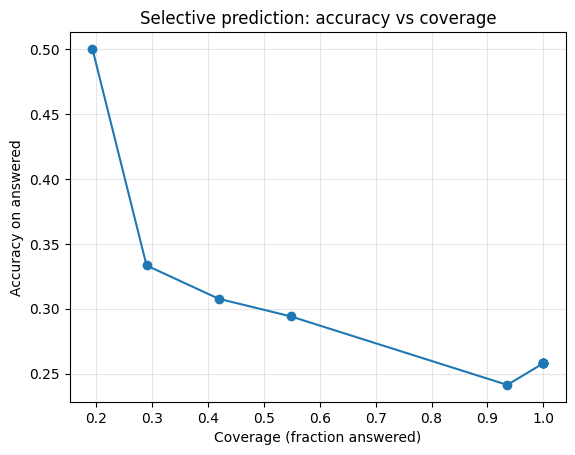

In [102]:
coverages, accs, taus, counts = selective_curve(p_te, y_test, min_answers=5, include_equal=True)

# (Optional) mask NaNs or low-count regions before plotting
mask = ~np.isnan(accs)
plt.plot(coverages[mask], accs[mask], marker='o')
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective prediction: accuracy vs coverage")
plt.grid(True, alpha=0.3)
plt.show()

In [104]:
print("Overall acc:", (p_te.argmax(1) == y_test).mean())
conf = p_te.max(1)
print("Conf min/mean/max:", conf.min(), conf.mean(), conf.max())
for t in [0.6, 0.8, 0.9, 0.95]:
    ans = conf >= t
    if ans.any():
        print(f"τ={t:.2f}: cov={ans.mean():.3f} acc={ (p_te.argmax(1)[ans]==y_test[ans]).mean():.3f} n={ans.sum()}")

Overall acc: 0.25806451612903225
Conf min/mean/max: 0.3584756 0.44313043 0.7128546
τ=0.60: cov=0.032 acc=1.000 n=1



### Reliability diagram (calibration curve) + ECE


ECE=0.221, MCE=0.287


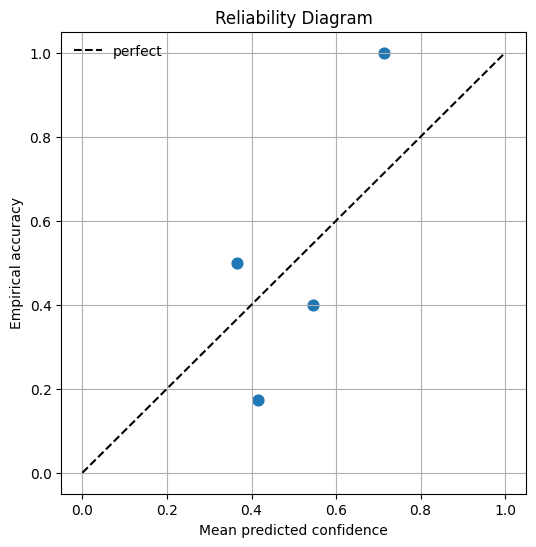

In [105]:

def reliability_curve(probs, y_true, bins=10):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    bin_ids = np.digitize(conf, bin_edges) - 1
    bin_acc, bin_conf, bin_count = [], [], []
    for b in range(bins):
        mask = bin_ids == b
        if mask.sum() > 0:
            bin_acc.append((pred[mask] == y_true[mask]).mean())
            bin_conf.append(conf[mask].mean())
            bin_count.append(mask.sum())
        else:
            bin_acc.append(np.nan); bin_conf.append(np.nan); bin_count.append(0)
    return np.array(bin_conf), np.array(bin_acc), np.array(bin_count), bin_edges

def expected_calibration_error(probs, y_true, bins=10):
    bin_conf, bin_acc, bin_cnt, _ = reliability_curve(probs, y_true, bins=bins)
    mask = ~np.isnan(bin_conf)
    weights = bin_cnt[mask] / bin_cnt[mask].sum() if bin_cnt[mask].sum()>0 else np.zeros_like(bin_cnt[mask], dtype=float)
    ece = np.sum(weights * np.abs(bin_acc[mask] - bin_conf[mask]))
    mce = np.max(np.abs(bin_acc[mask] - bin_conf[mask])) if mask.any() else np.nan
    return ece, mce, bin_conf, bin_acc

ece, mce, bin_conf, bin_acc = expected_calibration_error(p_te, y_test, bins=8)
print(f"ECE={ece:.3f}, MCE={mce:.3f}")

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"k--", label="perfect")
valid = ~np.isnan(bin_conf)
plt.scatter(bin_conf[valid], bin_acc[valid], s=60)
plt.xlabel("Mean predicted confidence"); plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram")
plt.grid(True); plt.legend(frameon=False); plt.show()



## 6) Per-question posterior predictive (mean ± 1σ) with true/pred markers


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def classify_with_uncertainty_sigma_auto(post, x_event, y_true=None, class_names=None, n_draws=None, entry_id=None):
    """
    Works with:
      - old path:  x_event shape (D,)           and post['W'] shape (S, D, C)
      - fast path: x_event shape (C, D)         and post['W'] shape (S, D, C)
    Plots mean ± 1σ, blue dot = predicted, red star = true.
    """
    W_s = post["W"]  # (S, D, C)
    B_s = post["b"]  # (S, C)
    S = W_s.shape[0]
    if n_draws and n_draws < S:
        idx = np.random.choice(S, size=n_draws, replace=False)
        W_s, B_s = W_s[idx], B_s[idx]

    def softmax(z):
        z = z - z.max()
        e = np.exp(z)
        return e / e.sum()

    probs = []
    for W, b in zip(W_s, B_s):
        logits = np.array([x_event[c] @ W[c, :] + b[c] for c in range(W.shape[0])])
        probs.append(softmax(logits))

    probs = np.stack(probs, axis=0)     # (S, C)
    mean = probs.mean(axis=0)
    std  = probs.std(axis=0)
    y_pred = int(mean.argmax())

    xs = np.arange(len(mean))
    labels = list(class_names) if class_names is not None else list(map(str, xs))

    # error bars only
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    # black dots = posterior mean
    plt.plot(xs, mean, "o", color="k", markersize=6)
    # predicted = blue dot
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)
    # true = red star
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)

    plt.xticks(xs, labels)
    plt.ylabel("Probability")
    plt.xlabel("Category")
    plt.ylim(0, 1)
    plt.title(f"Posterior for entry {entry_id}" if entry_id is not None else "Posterior (single question)")

    plt.legend(handles=[
        Line2D([0],[0], marker="o", color="k",   linestyle="none", markersize=6,  label="Posterior (mean ± 1σ)"),
        Line2D([0],[0], marker="o", color="blue",linestyle="none", markersize=10, label="Predicted"),
        Line2D([0],[0], marker="*", color="red", linestyle="none", markersize=14, label="True"),
    ], loc="best")
    plt.grid(alpha=0.3)
    plt.show()

    return mean, std, y_pred

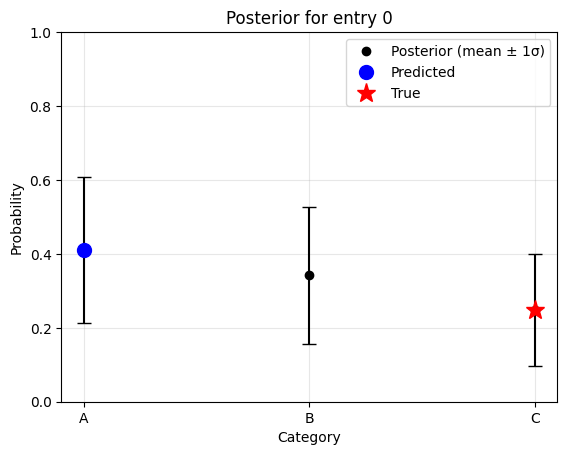

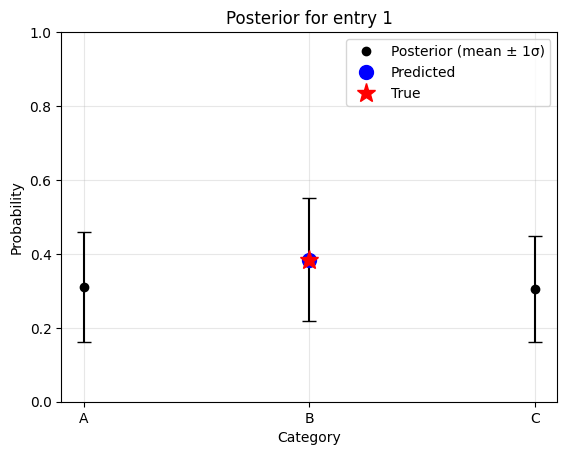

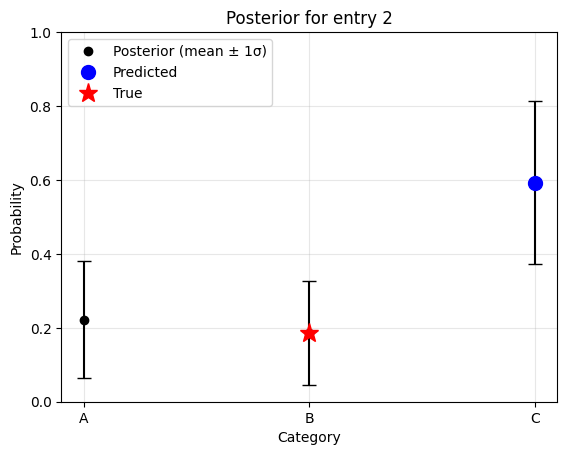

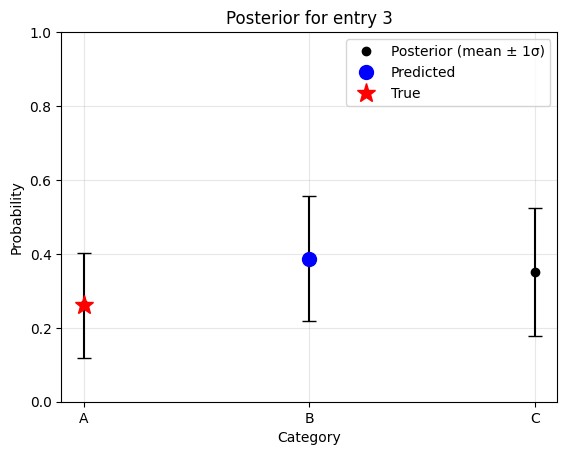

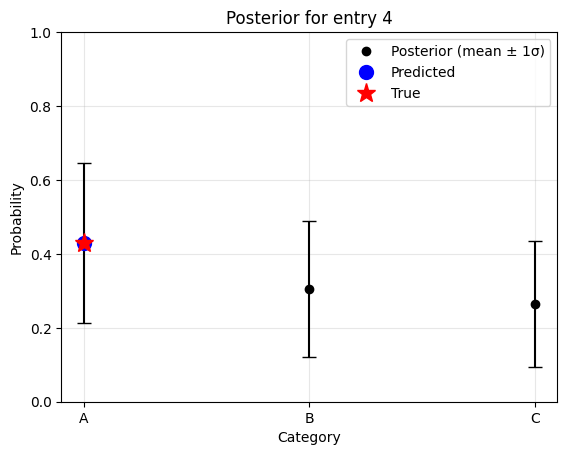

In [113]:
# Use the fast-path variables: post2, X_test2, y_test2
for i in range(min(5, len(X_test))):   # show a few examples
    classify_with_uncertainty_sigma_auto(
        posterior,
        X_test[i],                     # shape (C, D)
        y_true=int(y_test[i]),
        class_names=["A","B","C"],
        entry_id=i
    )


## 7) Notes & Next steps

- Replace the toy MCQ with a real dataset. Format into the same 3-option CSV and re-run.
- Ablations:
  - Head-only vs **LoRA adapters** + Laplace (see Experiment 3).
  - Compare to **temperature scaling** or **MC Dropout** baselines.
- Report **ECE/MCE** alongside reliability diagrams, and **selective prediction** curves.
